# EECE5644 Summer 1 2022 - HW1

Going over "solutions" for Assignment 1.

## Imports

In [1]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

from sys import float_info  # Threshold smallest positive floating value

import matplotlib.pyplot as plt # For general plotting

import numpy as np
import pandas as pd

from scipy.stats import norm, multivariate_normal
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title

## Utility Functions

In [2]:
def generate_data_from_gmm(N, pdf_params):
    # Determine dimensionality from mixture PDF parameters
    n = pdf_params['m'].shape[1]
    # Output samples and labels
    X = np.zeros([N, n])
    labels = np.zeros(N)
    
    # Decide randomly which samples will come from each component
    u = np.random.rand(N)
    thresholds = np.cumsum(pdf_params['priors'])
    thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

    L = np.array(range(1, len(pdf_params['priors'])+1))
    for l in L:
        # Get randomly sampled indices for this component
        indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
        # No. of samples in this component
        Nl = len(indices)  
        labels[indices] = l * np.ones(Nl) - 1
        if n == 1:
            X[indices, 0] =  norm.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
        else:
            X[indices, :] =  multivariate_normal.rvs(pdf_params['m'][l-1], pdf_params['C'][l-1], Nl)
    
    return X, labels

## Evaluation Functions

In [3]:
# Generate ROC curve samples
def estimate_roc(discriminant_score, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Sorting necessary so the resulting FPR and TPR axes plot threshold probabilities in order as a line
    sorted_score = sorted(discriminant_score)

    # Use gamma values that will account for every possible classification split
    gammas = ([sorted_score[0] - float_info.epsilon] +
              sorted_score +
              [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= g for g in gammas]
    
    # Retrieve indices where FPs occur
    ind10 = [np.argwhere((d == 1) & (labels == 0)) for d in decisions]
    # Compute FP rates (FPR) as a fraction of total samples in the negative class
    p10 = [len(inds) / N_labels[0] for inds in ind10]
    # Retrieve indices where TPs occur
    ind11 = [np.argwhere((d == 1) & (labels == 1)) for d in decisions]
    # Compute TP rates (TPR) as a fraction of total samples in the positive class
    p11 = [len(inds) / N_labels[1] for inds in ind11]
    
    # ROC has FPR on the x-axis and TPR on the y-axis, but return others as well for convenience
    roc = {}
    roc['p10'] = np.array(p10)
    roc['p11'] = np.array(p11)

    return roc, gammas


def get_binary_classification_metrics(predictions, labels):
    N_labels = np.array((sum(labels == 0), sum(labels == 1)))

    # Get indices and probability estimates of the four decision scenarios:
    # (true negative, false positive, false negative, true positive)
    class_metrics = {}
    
    # True Negative Probability Rate
    ind_00 = np.argwhere((predictions == 0) & (labels == 0))
    class_metrics['tnr'] = len(ind_00) / N_labels[0]
    # False Positive Probability Rate
    ind_10 = np.argwhere((predictions == 1) & (labels == 0))
    class_metrics['fpr'] = len(ind_10) / N_labels[0]
    # False Negative Probability Rate
    ind_01 = np.argwhere((predictions == 0) & (labels == 1))
    class_metrics['fnr'] = len(ind_01) / N_labels[1]
    # True Positive Probability Rate
    ind_11 = np.argwhere((predictions == 1) & (labels == 1))
    class_metrics['tpr'] = len(ind_11) / N_labels[1]

    return class_metrics

## Classifiers

In [4]:
def perform_lda(X, labels, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    In practice the mean and covariance parameters would be estimated from training samples.
    
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        mu: Mean vector [C, n].
        Sigma: Covariance matrices [C, n, n].

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """
    
    # First, estimate the class-conditional pdf mean and covariance matrices from samples
    # Note that reshape ensures my return mean vectors are of 2D shape (column vectors nx1)
    mu = np.array([np.mean(X[labels == i], axis=0).reshape(-1, 1) for i in range(C)])
    cov = np.array([np.cov(X[labels == i].T) for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z


# ERM classification rule (min prob. of error classifier)
def perform_erm_classification(X, Lambda, gmm_params, C):    
    # Conditional likelihoods of each x given each class, shape (C, N)
    class_cond_likelihoods = np.array([multivariate_normal.pdf(X, gmm_params['m'][c], gmm_params['C'][c]) for c in range(C)])

    # Take diag so we have (C, C) shape of priors with prior prob along diagonal
    class_priors = np.diag(gmm_params['priors'])
    # class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
    # with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
    class_posteriors = class_priors.dot(class_cond_likelihoods)

    # Conditional risk matrix of size C x N with each class as a row and N columns for samples
    risk_mat = Lambda.dot(class_posteriors)
    
    return np.argmin(risk_mat, axis=0)

## Question 1

The probability density function (pdf) for a 3-dimensional real-valued random vector $\mathbf{X}$ is as follows: $p(\mathbf{x}) = p(\mathbf{x}|L=0)P(L=0) + p(\mathbf{x}|L=1)P(L=1)$. Here $L$ is the true class label that indicates which class-label-conditioned pdf generates the data. 

The class priors are $P(L=0)=0.65$ and $P(L=1)=0.35$. 
The class class-conditional pdfs are $p(\mathbf{x}|L=0)=g(\mathbf{x}|\mathbf{m}_0,\mathbf{C}_0)$ and $p(\mathbf{x}|L=1)=g(\mathbf{x}|\mathbf{m}_1,\mathbf{C}_1)$, where $g(\mathbf{x}|\mathbf{m},\mathbf{C})$ is a multivariate Gaussian probability density function with mean vector $\mathbf{m}$ and covariance matrix $\mathbf{C}$. The parameters of the class-conditional Gaussian pdfs are:

\begin{equation*}
    \mathbf{m}_0=\begin{bmatrix} -1/2\\-1/2\\-1/2 \end{bmatrix} ~~~
    \mathbf{C}_0=\begin{bmatrix}1 & -0.5 & 0.3 \\-0.5 & 1 & -0.5 \\ 0.3 & -0.5 & 1\end{bmatrix} ~~~
    \mathbf{m}_1=\begin{bmatrix}1\\1\\1\end{bmatrix} ~~~
    \mathbf{C}_1=\begin{bmatrix}1 & 0.3 & -0.2 \\0.3 & 1 & 0.3 \\ -0.2 & 0.3 & 1\end{bmatrix}
\end{equation*}

For numerical results requested below, generate 10000 samples according to this data distribution, keep track of the true class labels for each sample. Save the data and use the same data set in all cases.

[6490 3510]


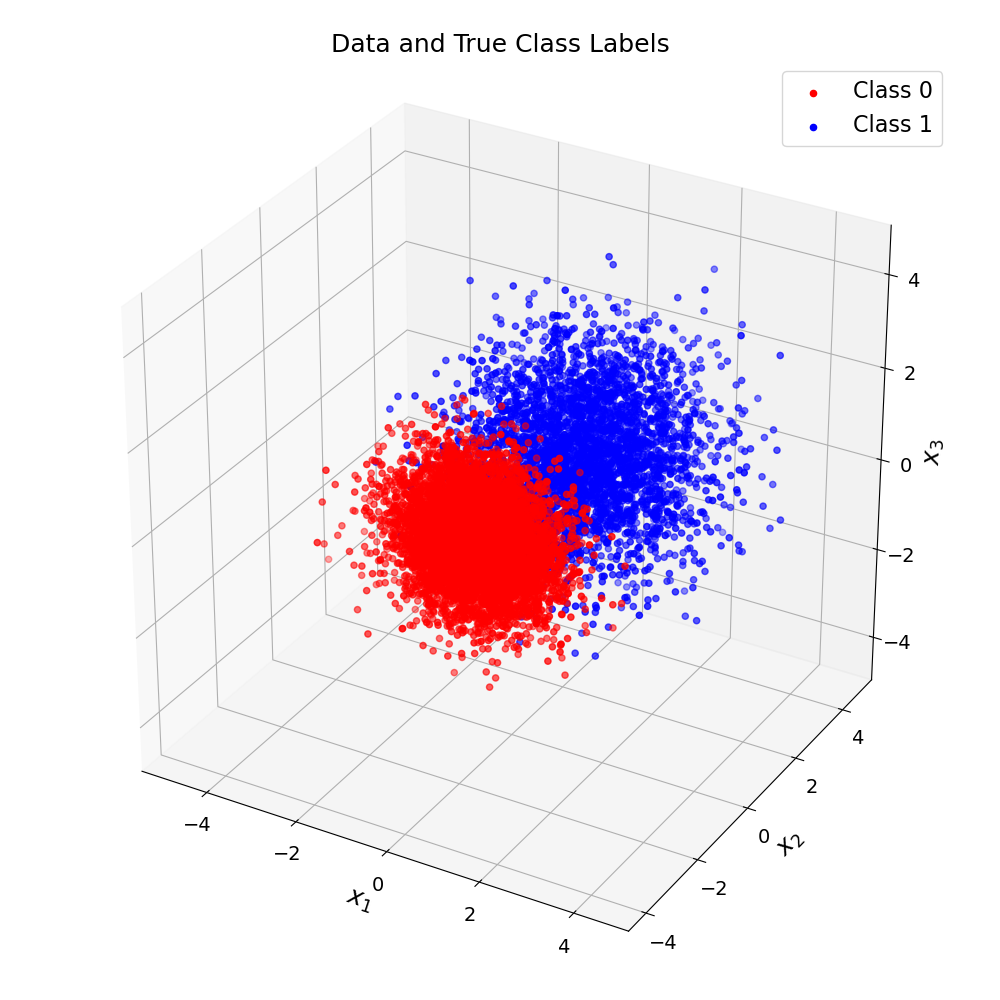

In [5]:
# Generate dataset from two different 3D Gaussian distributions/categories
N = 10000

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.65, 0.35])
num_classes = len(gmm_pdf['priors'])
# Mean and covariance of data pdfs conditioned on labels
gmm_pdf['m'] = np.array([[-0.5, -0.5, -0.5],
                         [1, 1, 1]])  # Gaussian distributions means
gmm_pdf['C'] = np.array([[[1, -0.5, 0.3],
                          [-0.5, 1, -0.5],
                          [0.3, -0.5, 1]],
                         [[1, 0.3, -0.2],
                          [0.3, 1, 0.3],
                          [-0.2, 0.3, 1]]])  # Gaussian distributions covariance matrices

# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))

ax_raw = fig.add_subplot(111, projection='3d')

X, labels = generate_data_from_gmm(N, gmm_pdf)

n = X.shape[1]
L = np.array(range(num_classes))

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)

ax_raw.scatter(X[labels == 0, 0], X[labels == 0, 1], X[labels == 0, 2], c='r', label="Class 0")
ax_raw.scatter(X[labels == 1, 0], X[labels == 1, 1], X[labels == 1, 2], c='b', label="Class 1")
ax_raw.set_xlabel(r"$x_1$")
ax_raw.set_ylabel(r"$x_2$")
ax_raw.set_zlabel(r"$x_3$")
# Set equal axes for 3D plots
ax_raw.set_box_aspect((np.ptp(X[:, 0]), np.ptp(X[:, 1]), np.ptp(X[:, 2])))

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()

### Part A: ERM classification using the knowledge of true data pdf

- Specify the minimum expected risk classification rule in the form of a likelihood-ratio test: $\frac{p(\mathbf{x}|L=1)}{p(\mathbf{x}|L=0)}\stackrel{?}{>}\gamma$, where the threshold $\gamma$ is a function of class priors and fixed (non-negative) loss values for each of the four cases $D=i|L=j$ where $D$ is the decision label that is either 0 or 1, like $L$.

> We will denote $\lambda_{ij} = \mathrm{Loss}(D=i|L=j)$, *i.e.*, $\lambda_{ij}$ is the loss associated with classifying an observation as label $i$ given that the true label was $j$. The likelihood ratio test used for classifying an observation $x$ is given by:

$$ \frac{p(x|L=1)}{p(x|L=0)} \overset{1}{\underset{0}{\gtrless}} \frac{(\lambda_{10} - \lambda_{00})}{(\lambda_{01} - \lambda_{11})} \frac{P(L=0)}{P(L=1)} \tag{1}. $$

Equating the right-hand side of the equation as $\gamma$ (given 0-1 loss) and taking the log of both sides, leads to the following decision rule:

$$ \ln{p(x|L=1)} - \ln{p(x|L=0)} \overset{1}{\underset{0}{\gtrless}} \ln{\gamma}. $$

- Implement this classifier and apply it on the 10K samples you generated. Vary the threshold $\gamma$ gradually from 0 to $\infty$, and for each value of the threshold compute the true positive (detection) probability $P(D=1|L=1;\gamma)$ and the false positive (false alarm) probability $P(D=1|L=0;\gamma)$. Using these paired values, trace/plot an approximation of the ROC curve of the minimum expected risk classifier. Note that at $\gamma=0$ The ROC curve should be at $(\begin{smallmatrix} 1\\1 \end{smallmatrix})$, and as $\gamma$ increases it should traverse towards $(\begin{smallmatrix} 0\\0 \end{smallmatrix})$. Due to the finite number of samples used to estimate probabilities, your ROC curve approximation should reach this destination value for a finite threshold value. Keep track of $(D=0|L=1;\gamma)$ and $P(D=1|L=0;\gamma)$ values for each $\gamma$ value for use in the next section.

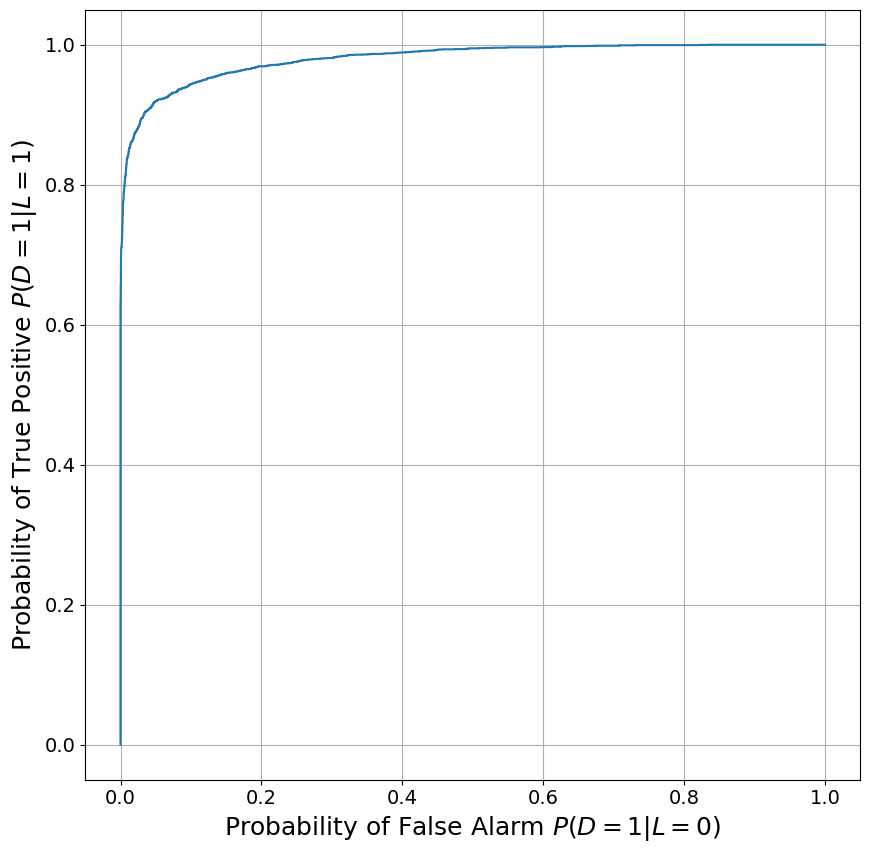

In [6]:
# Compute class conditional likelihoods to express ratio test, where ratio is discriminant score
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, gmm_pdf['m'][l], gmm_pdf['C'][l]) for l in L])
# Class conditional log likelihoods equate to decision boundary log gamma in the 0-1 loss case
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_erm, gammas_empirical = estimate_roc(discriminant_score_erm, labels)
# roc_erm returns a np.array of shape(2, N+2) where N+2 are the number of thresholds
# and 2 rows are the FPR and TPR respectively

plt.ioff() # Interactive plotting off
fig_roc, ax_roc = plt.subplots(figsize=(10, 10));
plt.ion()

ax_roc.plot(roc_erm['p10'], roc_erm['p11'], label="Empirical ERM Classifier ROC Curve")
ax_roc.set_xlabel(r"Probability of False Alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of True Positive $P(D=1|L=1)$")

plt.grid(True)
display(fig_roc)
fig_roc;

- Determine the threshold value that achieves minimum probability of error, and on the ROC curve, superimpose clearly (using a different color/shape marker) the true positive and false positive values attained by this minimum-P(error) classifier. Calculate and report an estimate of the minimum probability of error that is achievable for this data distribution. Note that $P(error;\gamma)=P(D=1|L=0;\gamma)P(L=0)+P(D=0|L=1;\gamma)P(L=1)$. How does your empirically selected $\gamma$ value that minimizes P(error) compare with the theoretically optimal threshold you compute from priors and loss values?

Min Empirical P(error) for ERM = 0.056
Min Empirical Gamma = 1.623
Min Theoretical P(error) for ERM = 0.057
Min Theoretical Gamma = 1.857


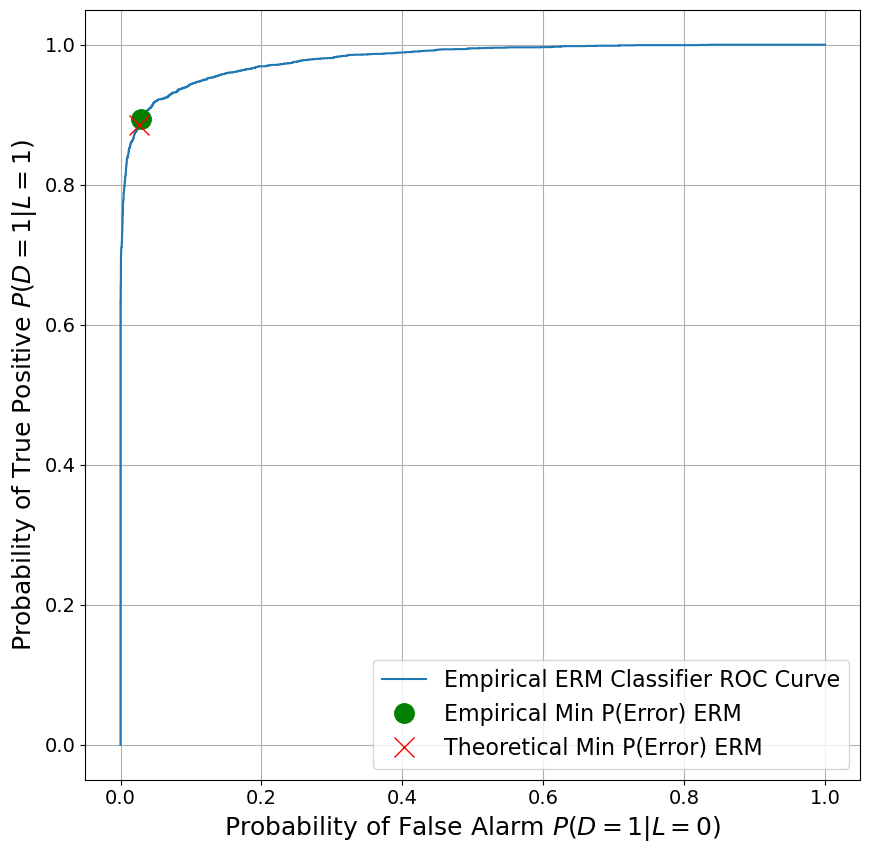

In [7]:
# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
# P(error; γ) = P(D = 1|L = 0; γ)P(L = 0)+P(D = 0|L = 1; γ)P(L = 1)
prob_error_empirical = np.array((roc_erm['p10'], 1 - roc_erm['p11'])).T.dot(N_per_l / N)

# Min prob error for the empirically-selected gamma thresholds
min_prob_error_empirical = np.min(prob_error_empirical)
min_ind_empirical = np.argmin(prob_error_empirical)

# Compute theoretical gamma as log-ratio of priors (0-1 loss) -> MAP classification rule
gamma_map = gmm_pdf['priors'][0] / gmm_pdf['priors'][1]
decisions_map = discriminant_score_erm >= np.log(gamma_map)

class_metrics_map = get_binary_classification_metrics(decisions_map, labels)
# To compute probability of error, we need FPR and FNR
min_prob_error_map = np.array((class_metrics_map['fpr'] * gmm_pdf['priors'][0] + 
                               class_metrics_map['fnr'] * gmm_pdf['priors'][1]))

# Plot theoretical and empirical
ax_roc.plot(roc_erm['p10'][min_ind_empirical], roc_erm['p11'][min_ind_empirical], 'go', label="Empirical Min P(Error) ERM",
            markersize=14)
ax_roc.plot(class_metrics_map['fpr'], class_metrics_map['tpr'], 'rx', label="Theoretical Min P(Error) ERM", markersize=14)
plt.legend()

print("Min Empirical P(error) for ERM = {:.3f}".format(min_prob_error_empirical))
print("Min Empirical Gamma = {:.3f}".format(np.exp(gammas_empirical[min_ind_empirical])))

print("Min Theoretical P(error) for ERM = {:.3f}".format(min_prob_error_map))
print("Min Theoretical Gamma = {:.3f}".format(gamma_map))

display(fig_roc)

### Part B 

ERM classification attempt using incorrect knowledge of data distribution (Naive Bayesian Classifier, which assumes features are independent given each class label)... For this part, assume that you know the true class prior probabilities, but for some reason you think that the class conditional pdfs are both Gaussian with the true means, but (incorrectly) with covariance matrices that are both equal to the identity matrix (with diagonal entries equal to true variances, off-diagonal entries equal to zeros, consistent with the independent feature assumption of Naive Bayes). Analyze the impact of this model mismatch in this Naive Bayesian (NB) approach to classifier design by repeating the same steps in Part A on the same 10K sample data set you generated earlier. Report the same results, answer the same questions. Did this model mismatch negatively impact your ROC curve and minimum achievable probability of error?

Min Naive P(error) for ERM = 0.067
Min Naive Gamma = 1.010


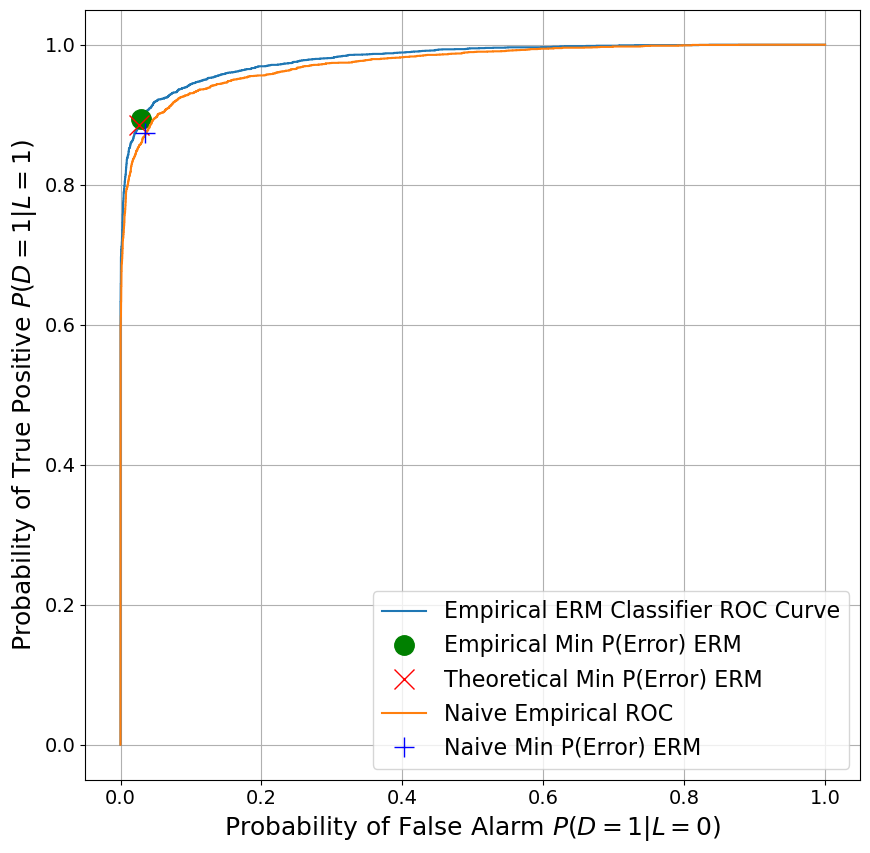

In [8]:
# Naive Bayes case assume conditional independence with features, zero covariance, zero off-diagonals
# Happens to be identity matrix in this question
naive_class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, gmm_pdf['m'][l], np.eye(n)) for l in L])
# Class conditional log likelihoods equate to decision boundary log gamma in the 0-1 loss case
discriminant_score_naive = np.log(naive_class_conditional_likelihoods[1]) - np.log(
    naive_class_conditional_likelihoods[0])

# Construct the ROC for ERM by changing log(gamma)
roc_naive, gammas_naive = estimate_roc(discriminant_score_naive, labels)

# P(error; γ) = P(D = 1|L = 0; γ)P(L = 0)+P(D = 0|L = 1; γ)P(L = 1)
prob_error_naive = np.array((roc_naive['p10'], (1 - roc_naive['p11']))).T.dot(N_per_l / N)

# Min prob error for the naive classifier gamma thresholds
min_prob_error_naive = np.min(prob_error_naive)
min_ind_naive = np.argmin(prob_error_naive)

# Plot naive min prob error
ax_roc.plot(roc_naive['p10'], roc_naive['p11'], label="Naive Empirical ROC")
ax_roc.plot(roc_naive['p10'][min_ind_naive], roc_naive['p11'][min_ind_naive], 'b+', label="Naive Min P(Error) ERM",
            markersize=14)
ax_roc.legend()

print("Min Naive P(error) for ERM = {:.3f}".format(min_prob_error_naive))
print("Min Naive Gamma = {:.3f}".format(np.exp(gammas_naive[min_ind_naive])))

display(fig_roc)

### Part C

In the third part of this exercise, repeat the same steps as in the previous two cases, but this time using a Fisher Linear Discriminant Analysis (LDA) based classifier. Using the 10K available samples, estimate the class conditional pdf mean and covariance matrices using sample average estimators for mean and covariance. From these estimated mean vectors and covariance matrices, determine the Fisher LDA projection weight vector (via the generalized eigendecomposition of within and between class scatter matrices): $\mathbf{w}_{LDA}$. For the classification rule $\mathbf{w}_{LDA}^T\mathbf{x}$ compared to a threshold $\tau$, which takes values from $-\infty$ to $\infty$, trace the ROC curve. Identify the threshold at which the probability of error (based on sample count estimates) is minimized, and clearly mark that operating point on the ROC curve estimate. Discuss how this LDA classifier performs relative to the previous two classifiers.

<i>Note: When finding the Fisher LDA projection matrix, do not be concerned about the difference in the class priors. When determining the between-class and within-class scatter matrices, use equal weights for the class means and covariances, like we did in class.</i>

Min LDA P(error) for ERM = 0.065
Min LDA Gamma = 0.323


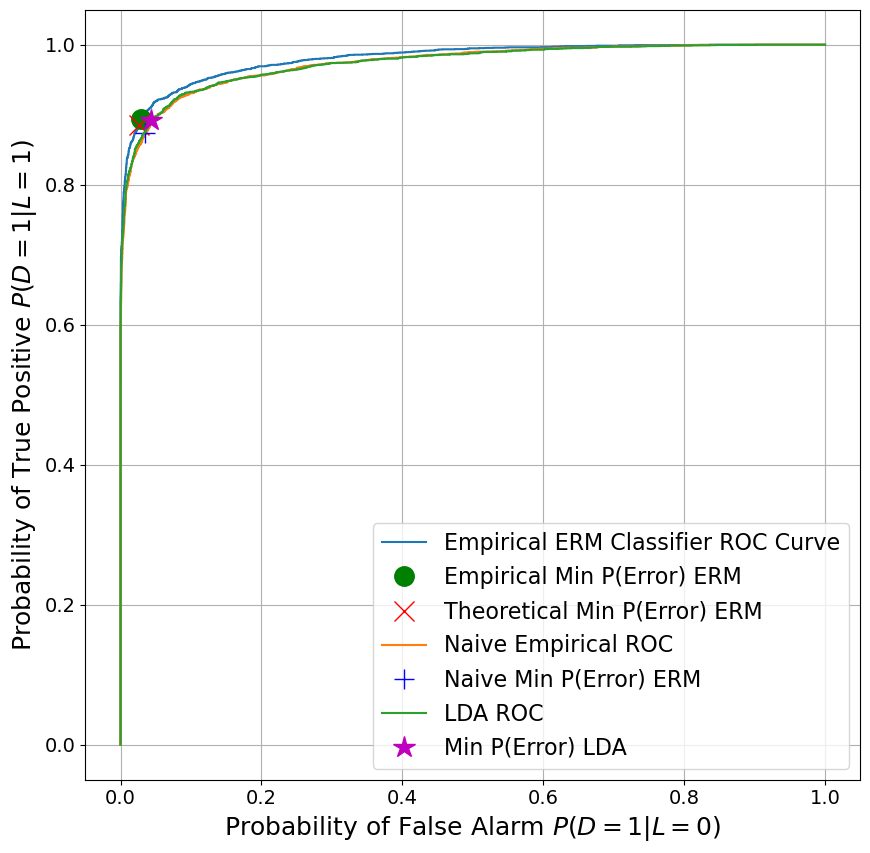

In [9]:
# Fisher LDA Classifer (using true model parameters)
_, discriminant_score_lda = perform_lda(X, labels)

# Estimate the ROC curve for this LDA classifier
roc_lda, gamma_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda['p10'], (1 - roc_lda['p11']))).T.dot(N_per_l / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind_lda = np.argmin(prob_error_lda)

# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda['p10'], roc_lda['p11'], label="LDA ROC")
ax_roc.plot(roc_lda['p10'][min_ind_lda], roc_lda['p11'][min_ind_lda], 'm*', label="Min P(Error) LDA",  markersize=16)
ax_roc.legend()


print("Min LDA P(error) for ERM = {:.3f}".format(min_prob_error_lda))
print("Min LDA Gamma = {:.3f}".format(np.real(gamma_lda[min_ind_lda])))

display(fig_roc)

Since the MAP classifier is designed to minimize probability error (when implemented with true class conditional likelihoods and class priors, as in Part A), we would expect its error probability to be lower than that of all other classifiers, including the Naive Bayes classifier and Fisher's LDA from Parts B and C, respectively. The numerical experiment is consistent with this theoretical result.

## Question 2

A 2-dimensional random vector $\mathbf{X}$ takes values from a mixture of four Gaussians. Each Gaussian pdf is the class-conditional pdf for one of four class labels $L\in \{1,2,3,4\}$. For this problem, pick your own 4 distinct Gaussian class conditional pdfs $p(\mathbf{x}|L=j),~j\in\{1,2,3,4\}$. Set class priors to $0.2,0.25,0.25,0.3$. Select your Gaussian class conditional pdfs to have mean vectors approximately equally spaced out along a line, and the covariance matrices to be scaled versions of the identity matrix (with scale factors that lead to a significant amount of overlap between the data from these Gaussians). Label these classes in order according to the ordering of mean vectors along the line, so that classes have consecutive integer labels.

In [10]:
n = 2 # dimensionality of input random vectors
C = 4 # number of classes

gmm_pdf = {}

# Class priors
gmm_pdf['priors'] = np.array([0.2, 0.25, 0.25, 0.3])

# Set mean vectors to be equally spaced out along a line in order
gmm_pdf['m'] = np.array([1*np.ones(n), 2*np.ones(n), 3*np.ones(n), 4*np.ones(n)])

# Set covariance matrices so that there is significant overlap between these
# distributions with means given above
gmm_pdf['C'] = np.array([3*np.eye(n), 3*np.eye(n), 3*np.eye(n), 3*np.eye(n)])

### Part A: Minimum probability of error classification (0-1 loss, aka Bayes Decision rule or MAP classifier)

- Generate 10000 samples from this data distribution and keep track of the true labels of each sample.

[2009 2506 2456 3029]


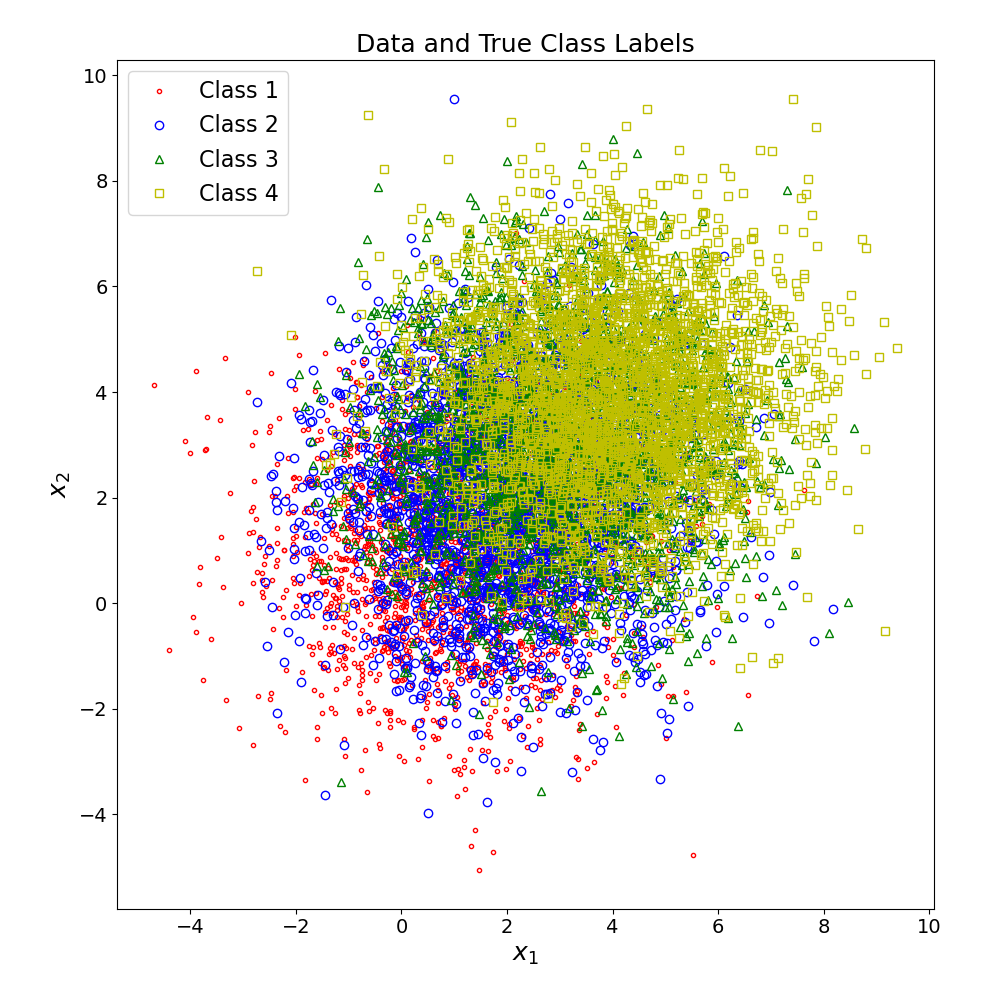

In [11]:
X, labels = generate_data_from_gmm(N, gmm_pdf)

L = np.array(range(C)) # Assuming 0-3 instead of 1-4 to make my life easier in Python

# Count up the number of samples per class
N_per_l = np.array([sum(labels == l) for l in L])
print(N_per_l)

# Plot the original data and their true labels
fig, ax_gmm = plt.subplots(figsize=(10, 10))

ax_gmm.plot(X[labels == 0, 0], X[labels == 0, 1], 'r.', label="Class 1", markerfacecolor='none')
ax_gmm.plot(X[labels == 1, 0], X[labels == 1, 1], 'bo', label="Class 2", markerfacecolor='none')
ax_gmm.plot(X[labels == 2, 0], X[labels == 2, 1], 'g^', label="Class 3", markerfacecolor='none')
ax_gmm.plot(X[labels == 3, 0], X[labels == 3, 1], 'ys', label="Class 4", markerfacecolor='none')
ax_gmm.set_xlabel(r"$x_1$")
ax_gmm.set_ylabel(r"$x_2$")
ax_gmm.set_aspect('equal')

plt.title("Data and True Class Labels")
plt.legend()
plt.tight_layout()

- Specify the decision rule that achieves minimum probability of error (i.e., use 0-1 loss), implement this classifier with the true data distribution knowledge, classify the 10K samples and count the samples corresponding to each decision-label pair to empirically estimate the confusion matrix whose entries are $P(D=i|L=j)$ for $i,j\in\{1,2,3,4\}$. Present the results.

For a given $x$, we want to choose a class label $i$ which minimizes risk (or loss) associated with choosing this class label. We know that the ERM decision rule for this problem is based on conditional risk:

$$ D(\mathbf{x}) = \mathop{\rm argmin}_{i\in \{1,2,3,4\}} \sum_{i=1}^4 R(D(\mathbf{x}) = i \, | \, \mathbf{x}) = \mathop{\rm argmin}_{i \in \{1,2,3,4\}} \sum_{i=1}^4 \lambda_{ij} p(\mathbf{x}\, | \,Y=j)P(Y=j), $$

where the expression expands the class posteriors $P(Y=j \, | \, \mathbf{x})$ for $j \in \{1,2,3,4\}$  using Bayes rule.

You can find the matrix form is expressed as:

$$ \begin{bmatrix} R(D(\mathbf{x})=1\, | \,\mathbf{x}) \\  R(D(\mathbf{x})=2\, | \,\mathbf{x}) \\ R(D(\mathbf{x})=3\, | \,\mathbf{x}) \\ R(D(\mathbf{x})=4\, | \,\mathbf{x}) \end{bmatrix} = \mathbf{\Lambda} \begin{bmatrix} P(Y=1\, | \,\mathbf{x}) \\ P(Y=2\, | \,\mathbf{x}) \\ P(Y=3\, | \,\mathbf{x}) \\ P(Y=4\, | \,\mathbf{x}) \end{bmatrix} = \mathbf{\Lambda} \, \text{diag}\big(P(Y=1), P(Y=2), P(Y=3), P(Y=4)  \big) \begin{bmatrix} p(\mathbf{x}\, | \,Y=1) \\ p(\mathbf{x}\, | \,Y=2) \\ p(\mathbf{x}\, | \,Y=3) \\ p(\mathbf{x}\, | \,Y=4) \end{bmatrix}$$

The decision $D(\mathbf{x})$ resulting in minimum conditional risk (minimum entry in the vector on the left-hand side of this equation) will be elected.

In [12]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((C, C)) - np.eye(C)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Confusion Matrix (rows: Predicted class, columns: True class):
[[1116  612  175   24]
 [ 679 1072  684  288]
 [ 153  463  573  495]
 [  61  359 1024 2222]]
Total Mumber of Misclassified Samples: 5017
Empirically Estimated Probability of Error: 0.5017


- Provide a visualization of the data (scatter-plot in 2-dimensional space), and for each sample indicate the true class label with a different marker shape (dot, circle, triangle, square) and whether it was correctly (green) or incorrectly (red) classified with a different marker color as indicated in parentheses.

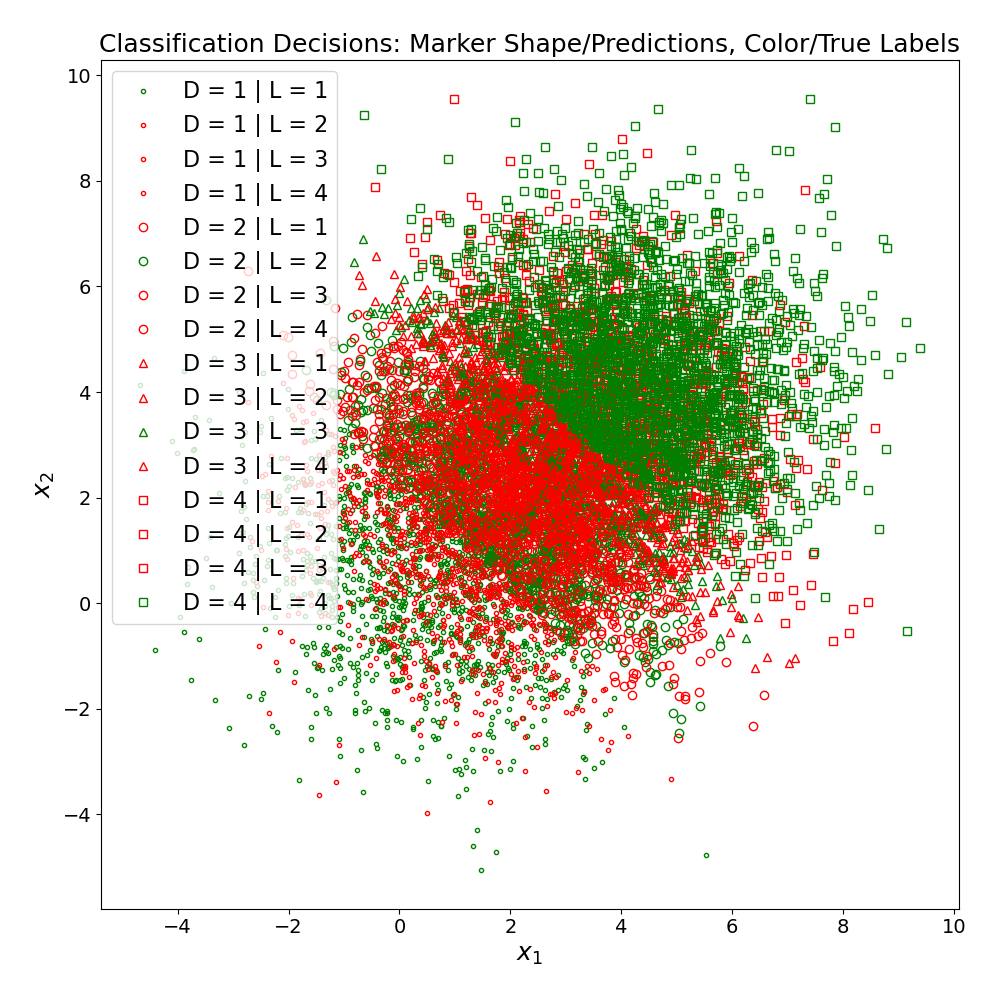

In [13]:
# Plot for decisions vs true labels
fig_map = plt.figure(figsize=(10, 10))

marker_shapes = '.o^s'
for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c))

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c:
            marker = marker_shapes[r] + 'g'
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker,
                     label="D = {} | L = {}".format(r+1, c+1), markerfacecolor='none')
        else:
            marker = marker_shapes[r] + 'r'
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker,
                     label="D = {} | L = {}".format(r+1, c+1), markerfacecolor='none')

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

### Part B

Repeat the exercise for the ERM classification rule with the following loss values (errors between Gaussian pairs that have higher separation in their means will be penalized more):
    \begin{equation}
        \Lambda =
        \begin{bmatrix}
            0 & 1 & 2 & 3\\
            1 & 0 & 1 & 2\\
            2 & 1 & 0 & 1\\
            3 & 2 & 1 & 0\\
        \end{bmatrix}
    \end{equation}

Note that, the $(i,j)^{th}$ entry of the loss matrix indicates the loss incurred by deciding on class $i$ when the true label is $j$. For this part, using the 10K samples, estimate the minimum expected risk that this optimal ERM classification rule will achieve. Present your results with visual and numerical representations. Briefly discuss interesting insights, if any.

<i>Hint: For each sample, determine the loss matrix entry corresponding to the decision-label pair that this sample falls into, and add this loss to an estimate of cumulative loss. Divide cumulative loss by the number of samples to get average loss as an estimate for expected loss.</i>

Confusion Matrix (rows: Predicted class, columns: True class):
[[ 814  354   86   14]
 [ 941 1225  674  246]
 [ 237  756 1066 1110]
 [  17  171  630 1659]]
Total Mumber of Misclassified Samples: 5236
Empirically Estimated Probability of Error: 0.5236


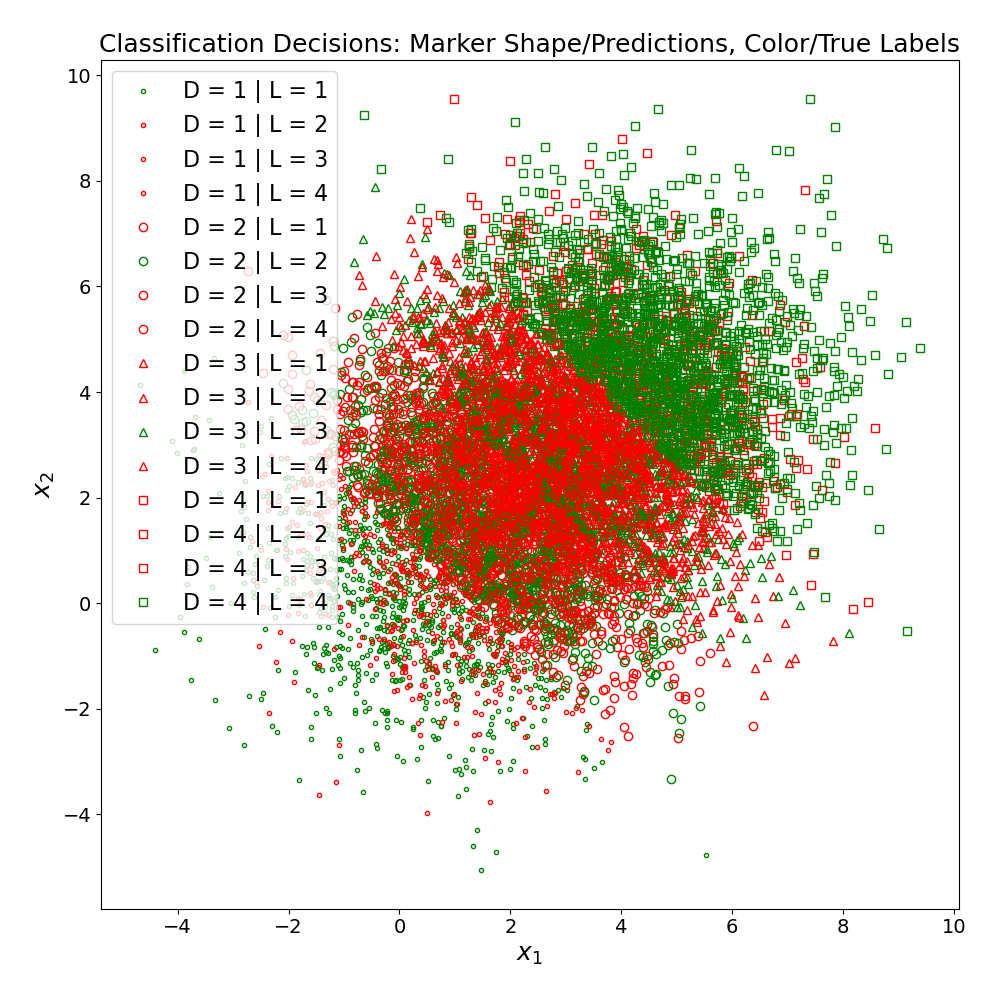

In [14]:
# Create the new loss matrix
Lambda = np.array([[0, 1, 2, 3], 
                   [1, 0, 1, 2], 
                   [2, 1, 0, 1], 
                   [3, 2, 1, 0]])

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm_pdf, C)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)
correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

# Plot for decisions vs true labels
fig_erm = plt.figure(figsize=(10, 10))

marker_shapes = '.o^s'
for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c))

        # Decision = Marker Shape; True Labels = Marker Color
        if r == c:
            marker = marker_shapes[r] + 'g'
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker,
                     label="D = {} | L = {}".format(r+1, c+1), markerfacecolor='none')
        else:
            marker = marker_shapes[r] + 'r'
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker,
                     label="D = {} | L = {}".format(r+1, c+1), markerfacecolor='none')

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

The ERM classifier using the loss matrix from Part B differs from Part A in how it penalizes misclassifications made for classes farther away more than those made for adjacent classes. One might expect higher error for Part B's ERM classifier, as a result of using a loss matrix $\boldsymbol{\Lambda}$ that places higher risk than a 0-1 loss function on classifying samples from non-adjectent distributions. Therefore, the priority of the Part B classifer is to correctly classify those few outlier class samples that could be misconstrued for a distant, incorrect class. However, this effect may come at the expense of penalizing relatively less than Part A's classifier the more frequently occurring adjacent class samples.

Specifically, we would anticipate that Part B's classifier decreases false probability scores over Part A's classifier in the following scenarios $D = 4 | L = 1$, $D = 1 | L = 4$ (higher risk associated with deciding class 4 given the class was actually 1, and vice versa), as is demonstrated in the above confusion matrices. This behaviour becomes more pronounced in the presence of class-conditional pdfs with significant overlap.

## Question 3

Implement minimum-probability-of-error classifiers for the following problems, assuming that the class conditional pdf of features for each class you encounter is a Gaussian.

I used [pandas](https://pandas.pydata.org/) for the dataset parsing aspect of this question. It's an extremely useful and flexible tool when it comes to data manipulation/analysis, so I highly encouraging investigating its features for future use.


### Wine Quality Dataset

Wine Quality dataset located [here](https://archive.ics.uci.edu/ml/datasets/Wine+Quality), specifically the <b>white</b> wine dataset, which consists of 11 features, and class labels from 0 to 10 indicating wine quality scores. There are 4898 samples.

In [15]:
wine_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                       delimiter=';')

# Sanity check
wine_df

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                    45.0                 170.0  1.00100  3.00       0.45   
1                    14.0                 132.0  0.99400  3.30       0.49   
2                    30.0                  97.0  0.99510  3.26       0.44   
3                    47.0                 186.0  0.99560  3.19       0.40   
4                    47.0                 186.0  0.99560  3.19       0.40   
...                   ...                   ...      ...   ...        ...   
4893                 24.0                  92.0  0.99114  3.27       0.50   
4894                 57.0                 168.0  0.99490  3.15       0.46   
4895                 30.0                 111.0  0.99254  2.99       0.46   
4896                 20.0                 110.0  0.98869  3.34       0.38   
4897                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  
0         8.8        6  
1         9.5        6  
2        10.1        6  
3         9.9        6  
4         9.9        6  
...       ...      ...  
4893     11.2        6  
4894      9.6        5  
4895      9.4        6  
4896     12.8        7  
4897     11.8        6  

[4898 rows x 12 columns]

Using all available samples from a class, estimate mean vectors and covariance matrices with sample averages. Using sample counts, also estimate class priors. In case your sample estimates of covariance matrices are ill-conditioned, consider adding a regularization term to your covariance estimate as in: $\mathbf{C}_{Regularized} = \mathbf{C}_{SampleAverage} + \lambda \mathbf{I}$ where $\lambda>0$ is a small regularization parameter that ensures the regularized covariance matrix $\mathbf{C}_{Regularized}$ has all eigenvalues larger than this parameter.

In [16]:
def regularized_cov(X, lambda_reg):
    n = X.shape[0]
    sigma = np.cov(X)
    # Selecting the regularization parameter should be performed using CV and a separate data subset
    # As I only went by training set performance (overfitting) in this problem, I settled on lambda=1/n
    sigma += lambda_reg * np.eye(n)
    return sigma

# Total number of rows/samples
N = len(wine_df.index)

# iloc accesses rows/columns by indexing 
# Extracting data matrix X and target labels vector
X = wine_df.iloc[:, :-1].to_numpy()
qualities = wine_df.iloc[:, -1].to_numpy()

# Define a label encoder to make indexing easy and encode labels as 0, 1, ..., C, rather than 4, 5, ... etc
le = preprocessing.LabelEncoder()
le.fit(qualities)
labels = le.transform(qualities)

# Estimate class priors
gmm = {}
gmm['priors'] = (wine_df.groupby(['quality']).size() / N).to_numpy() 
# Infer number of classes from priors
num_classes = len(gmm['priors'])

gmm['m'] = wine_df.groupby(['quality']).mean().to_numpy() 
# Infer number of features from priors
n = gmm['m'].shape[1]

gmm['C'] = np.array([regularized_cov(X[labels == l].T, (1/n)) for l in range(num_classes)])

N_per_l = np.array([sum(labels == l) for l in range(num_classes)])
print(N_per_l)

[  20  163 1457 2198  880  175    5]


With these estimated (trained) Gaussian class conditional pdfs and class priors, apply the minimum-P(error) classification rule on all (training) samples, count the errors, and report the error probability estimate you obtain for each problem, as well as the confusion matrices for this classification rule. 

In [17]:
# If 0-1 loss then yield MAP decision rule, else ERM classifier
Lambda = np.ones((num_classes, num_classes)) - np.eye(num_classes)

# ERM decision rule, take index/label associated with minimum conditional risk as decision (N, 1)
decisions = perform_erm_classification(X, Lambda, gmm, num_classes)

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)

correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Confusion Matrix (rows: Predicted class, columns: True class):
[[   7    2    5   12    2    4    0]
 [   1    3    7    6    0    0    0]
 [   5  105  934  614  100   16    0]
 [   7   50  491 1339  472   79    2]
 [   0    3   19  227  303   73    3]
 [   0    0    1    0    3    3    0]
 [   0    0    0    0    0    0    0]]
Total Mumber of Misclassified Samples: 2309
Empirically Estimated Probability of Error: 0.4714


Visualize the datasets in 2- or 3-dimensional projections of subsets of features and then do the same 2- or 3-dimensional plots using principal component analysis (PCA). Discuss the following:

 - If Gaussian class conditional models are appropriate for these datasets, commenting on the differences in how feature-subsets or PCA helped you draw your conclusions
 - How your model choice might have influenced the confusion matrix and probability of error values you obtained
 - Any modeling assumptions, e.g. how you estimated/selected necessary parameters for your model and classification rule

Describe your analyses in mathematical terms supplemented by numerical and visual results, conveying your understanding of what you have accomplished and demonstrated.

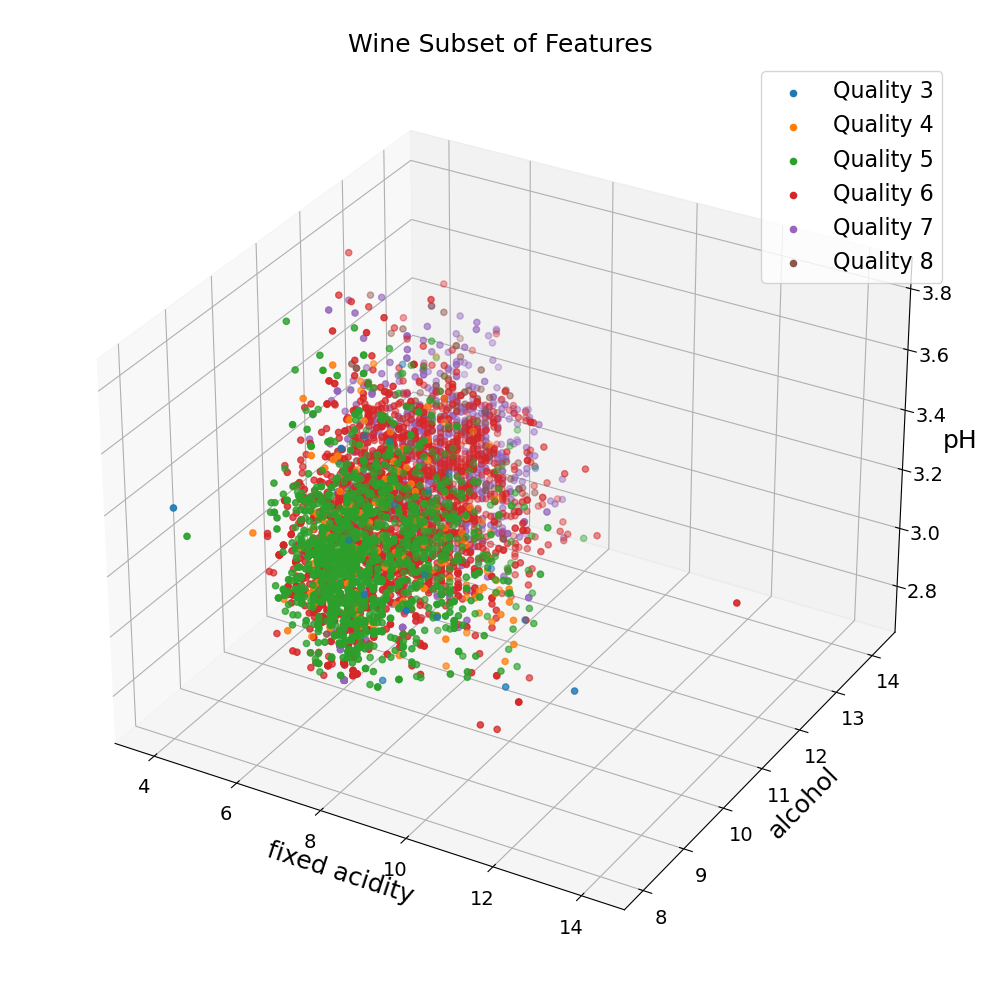

In [18]:
fig = plt.figure(figsize=(10, 10))

ax_subset = fig.add_subplot(111, projection='3d')

unique_qualities = np.sort(wine_df['quality'].unique())
for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_subset.scatter(wine_df[wine_df['quality']==q]['fixed acidity'], 
                      wine_df[wine_df['quality']==q]['alcohol'], 
                      wine_df[wine_df['quality']==q]['pH'], label="Quality {}".format(q))
    
ax_subset.set_xlabel("fixed acidity")
ax_subset.set_ylabel("alcohol")
ax_subset.set_zlabel("pH")

# Set equal axes for 3D plots to realize the additional challenges in visualization
# ax_subset.set_box_aspect((np.ptp(wine_df['fixed acidity']), np.ptp(wine_df['alcohol']), np.ptp(wine_df['pH'])))

plt.title("Wine Subset of Features")
plt.legend()
plt.tight_layout()
plt.show()

The purpose of asking you to plot feature subsets or perform PCA over the data was to visualize the "Gaussian-like" resemblance of the data. As a key assumption in your model that the class-conditional pdfs are Gaussian, it is a sensible idea to validate this assumption by inspecting the data. Normally this step should take place prior to any classification, or deriving of probability of error estimates.

The subset of features part of the task was to illustrate that it's challenging to select appropriate feature subsets of 2/3-dimensions to plot... Even though $n=11$ is still fairly manageable, what about the HAR dataset with $n=561$? Domain knowledge would be immensely helpful in selecting these subsets, but we often lack such information. I personally arbitrarily chose features over a similar range of values, as I'm no wine expert.

A better approach here would be to employ a dimensionality reduction technique, such as PCA, which will help us build better intuition of whether we have selected an appropriate model (determined by our Gaussian class-conditional distributions) for the wine-quality classification task:

Explained variance ratio:  [0.90965734 0.07933386 0.01015427]


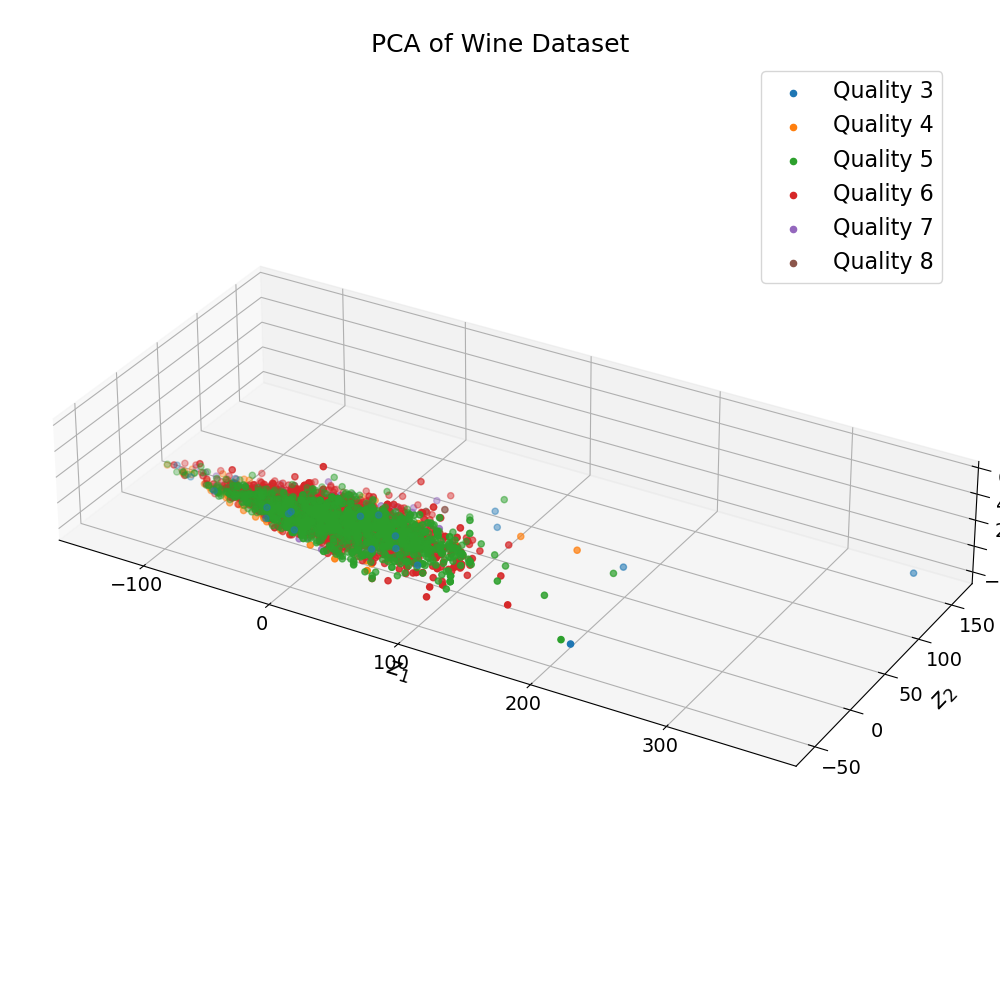

In [19]:
fig = plt.figure(figsize=(10, 10))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

for q in range(unique_qualities[0], unique_qualities[-1]):
    ax_pca.scatter(Z[wine_df['quality']==q, 0], 
                      Z[wine_df['quality']==q, 1], 
                      Z[wine_df['quality']==q, 2], label="Quality {}".format(q))
    
ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of Wine Dataset")
plt.legend()
plt.tight_layout()
plt.show()

The PCA procedure was effective at reducing the dimensionality of the data (fraction of variance explained primarily captured in the first three PCs), with a general Gaussian-like shape emerging (elliptical patterns). However, for this small $N$ case (CLT), the data is unlikely to follow a typical Gaussian distribution and our Gaussian assumption will introduce <b>model error</b>.

The most likely source for high probability of error estimates in this problem is due to <b>irreducible error</b>. The labelled projection plots illustrate significant amounts of overlap between the class-specific Gaussian pdfs, suggesting our model will struggle to correctly discriminate between classes based on conditional likelhood. The confusion matrix further highlights the effect of this overlap, demonstrating that classes are often mislabelled as middle wine quality scores (e.g., 5, 6 or 7), which are the most frequently occurring qualities with class-conditional pdfs responsible for the majority of spread in the data.

Overall, another model should be chosen for this task in order to clearly distinguish between the classes, as our Gaussian assumption is not entirely appropriate.


### Human Activity Recognition

Human Activity Recognition dataset located [here](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones), which consists of 561 features, and 6 activity labels. There are 10299 samples.

I won't finish this question but put in some quick code.

In [20]:
from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

# Reads zip file without writing to disk by emulating the file using a BytesIO buffer class 
resp = urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip')
har_zip = ZipFile(BytesIO(resp.read()))
har_train_df = pd.read_csv(har_zip.open('UCI HAR Dataset/train/X_train.txt'), delim_whitespace=True, header=None)
har_test_df = pd.read_csv(har_zip.open('UCI HAR Dataset/test/X_test.txt'), delim_whitespace=True, header=None)
har_df = pd.concat([har_train_df, har_test_df])

# Sanity check
har_df

# You can obtain the labels in a similar way^

0         1         2         3         4         5         6    \
0     0.288585 -0.020294 -0.132905 -0.995279 -0.983111 -0.913526 -0.995112   
1     0.278419 -0.016411 -0.123520 -0.998245 -0.975300 -0.960322 -0.998807   
2     0.279653 -0.019467 -0.113462 -0.995380 -0.967187 -0.978944 -0.996520   
3     0.279174 -0.026201 -0.123283 -0.996091 -0.983403 -0.990675 -0.997099   
4     0.276629 -0.016570 -0.115362 -0.998139 -0.980817 -0.990482 -0.998321   
...        ...       ...       ...       ...       ...       ...       ...   
2942  0.310155 -0.053391 -0.099109 -0.287866 -0.140589 -0.215088 -0.356083   
2943  0.363385 -0.039214 -0.105915 -0.305388  0.028148 -0.196373 -0.373540   
2944  0.349966  0.030077 -0.115788 -0.329638 -0.042143 -0.250181 -0.388017   
2945  0.237594  0.018467 -0.096499 -0.323114 -0.229775 -0.207574 -0.392380   
2946  0.153627 -0.018437 -0.137018 -0.330046 -0.195253 -0.164339 -0.430974   

           7         8         9    ...       551       552       553  \
0    -0.983185 -0.923527 -0.934724  ... -0.074323 -0.298676 -0.710304   
1    -0.974914 -0.957686 -0.943068  ...  0.158075 -0.595051 -0.861499   
2    -0.963668 -0.977469 -0.938692  ...  0.414503 -0.390748 -0.760104   
3    -0.982750 -0.989302 -0.938692  ...  0.404573 -0.117290 -0.482845   
4    -0.979672 -0.990441 -0.942469  ...  0.087753 -0.351471 -0.699205   
...        ...       ...       ...  ...       ...       ...       ...   
2942 -0.148775 -0.232057  0.185361  ...  0.074472 -0.376278 -0.750809   
2943 -0.030036 -0.270237  0.185361  ...  0.101859 -0.320418 -0.700274   
2944 -0.133257 -0.347029  0.007471  ... -0.066249 -0.118854 -0.467179   
2945 -0.279610 -0.289477  0.007471  ... -0.046467 -0.205445 -0.617737   
2946 -0.218295 -0.229933 -0.111527  ... -0.010386 -0.072237 -0.436940   

           554       555       556       557       558       559       560  
0    -0.112754  0.030400 -0.464761 -0.018446 -0.841247  0.179941 -0.058627  
1     0.053477 -0.007435 -0.732626  0.703511 -0.844788  0.180289 -0.054317  
2    -0.118559  0.177899  0.100699  0.808529 -0.848933  0.180637 -0.049118  
3    -0.036788 -0.012892  0.640011 -0.485366 -0.848649  0.181935 -0.047663  
4     0.123320  0.122542  0.693578 -0.615971 -0.847865  0.185151 -0.043892  
...        ...       ...       ...       ...       ...       ...       ...  
2942 -0.337422  0.346295  0.884904 -0.698885 -0.651732  0.274627  0.184784  
2943 -0.736701 -0.372889 -0.657421  0.322549 -0.655181  0.273578  0.182412  
2944 -0.181560  0.088574  0.696663  0.363139 -0.655357  0.274479  0.181184  
2945  0.444558 -0.819188  0.929294 -0.008398 -0.659719  0.264782  0.187563  
2946  0.598808 -0.287951  0.876030 -0.024965 -0.660080  0.263936  0.188103  

[10299 rows x 561 columns]

Explained variance ratio:  [0.62227069 0.04772595 0.04018191]


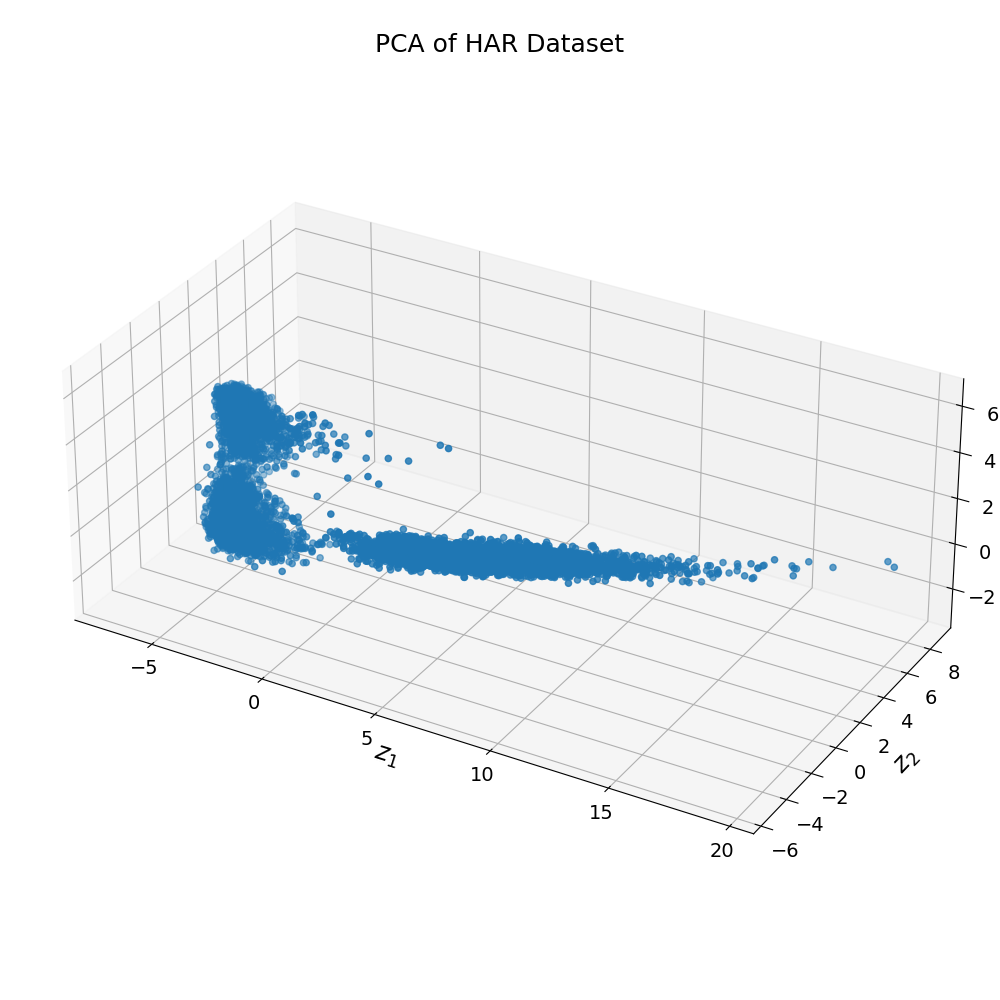

In [21]:
# Extracting data matrix X
X = har_df.to_numpy()

fig = plt.figure(figsize=(10, 10))

ax_pca = fig.add_subplot(111, projection='3d')

pca = PCA(n_components=3)  # n_components is how many PCs we'll keep
X_fit = pca.fit(X)  # Is a fitted estimator, not actual data to project
Z = pca.transform(X)

# Illustrates that we have at least 90% of the total variance captured by the PCA
print("Explained variance ratio: ", pca.explained_variance_ratio_)

ax_pca.scatter(Z[:, 0], Z[:, 1], Z[:, 2])
    
ax_pca.set_xlabel(r"$z_1$")
ax_pca.set_ylabel(r"$z_2$")
ax_pca.set_zlabel(r"$z_3$")

ax_pca.set_box_aspect((np.ptp(Z[:, 0]), np.ptp(Z[:, 1]), np.ptp(Z[:, 2])))

plt.title("PCA of HAR Dataset")
plt.tight_layout()
plt.show()

Still doesn't appear Gaussian-like (even when viewing each blob as a separate component distribution). Nevertheless, we have higher $N$ here (CLT assumption of tending towards Gaussian), so we might anticipate that a Gaussian model will perform well, or at least better than in the Wine dataset case. Moreover, even without labelled scatter points, the separation between "blobs" ([why I call them blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html)) will also hopefully improve our odds of classifying the activity labels from this dataset using a Gaussian-based model.